In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = DeprecationWarning)


In [5]:
df_links = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data/ml-latest-small/links.csv"))
df_movies = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data/ml-latest-small/movies.csv"))
df_ratings = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data/ml-latest-small/ratings.csv"))
df_tags = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data/ml-latest-small/tags.csv"))
genres_dummies = pd.get_dummies(df_movies['genres'].str.split('|').apply(pd.Series).stack()).groupby(level=0).sum()
df_movies = pd.concat([df_movies[['movieId', 'title']], genres_dummies], axis=1)
print(df_tags.head(5))
print(df_ratings.head(5))
print(df_movies.head(5))
print(df_links.head(5))

   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  (no genres listed)  Action  \
0        1                    Toy Story (1995)                   0       0   
1        2                      Jumanji (1995)                   0       0   
2        3             Grumpier Old Men (1995)                   0       0   
3        4            Waiting to Exhale (1995)                   0       0   
4        5  Father of the Bride Part II (1995)                   0       0   

   Adventure  A

# Phase 1

What is the distribution of the number of ratings by movie? What about by user? 

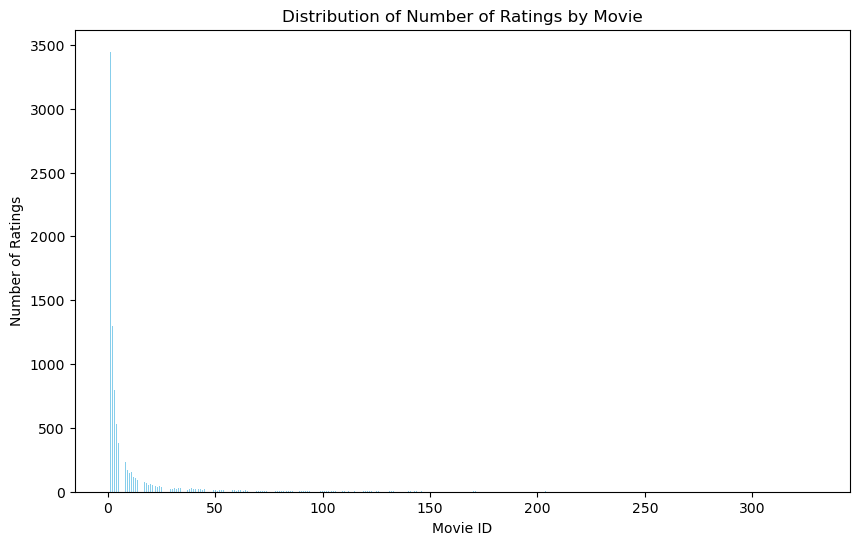

In [6]:
ratingByMovie = df_ratings.groupby('movieId')['rating'].count()

plt.figure(figsize=(10, 6))
plt.hist(ratingByMovie.values, bins=1000, color='skyblue' )
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Number of Ratings by Movie')
plt.show()

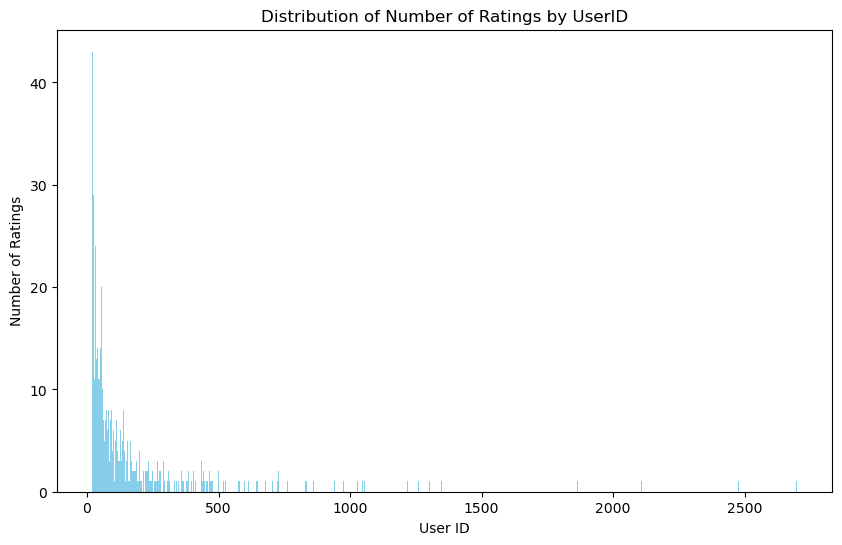

In [7]:
ratingByUser = df_ratings.groupby('userId')['rating'].count()

plt.figure(figsize=(10, 6))
plt.hist(ratingByUser.values, bins=1000, color='skyblue' )
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Number of Ratings by UserID')
plt.show()

What movie has the most ratings? The least?

In [5]:
print(f'The most rated movie is {df_movies[df_movies["movieId"] == ratingByMovie.idxmax()]["title"]}')
print(f'The most least movie is {df_movies[df_movies["movieId"] == ratingByMovie.idxmin()]["title"]}')

The most rated movie is 314    Forrest Gump (1994)
Name: title, dtype: object
The most least movie is 45    When Night Is Falling (1995)
Name: title, dtype: object


What movies have the highest ratings? Or the lowest ratings?

In [6]:
averageRatingByMovie = df_ratings.groupby('movieId')['rating'].mean()
print(f'The top 5 rated movies are')
for movie in averageRatingByMovie.nlargest(5).index:
    print(f'{df_movies[df_movies["movieId"] == movie]["title"]}')


print(f'The bottom 5 rated movies are')
for movie in averageRatingByMovie.nsmallest(5).index:
    print(f'{df_movies[df_movies["movieId"] == movie]["title"]}')

The top 5 rated movies are
48    Lamerica (1994)
Name: title, dtype: object
87    Heidi Fleiss: Hollywood Madam (1995)
Name: title, dtype: object
121    Awfully Big Adventure, An (1995)
Name: title, dtype: object
405    Live Nude Girls (1995)
Name: title, dtype: object
432    In the Realm of the Senses (Ai no corrida) (1976)
Name: title, dtype: object
The bottom 5 rated movies are
2689    Gypsy (1962)
Name: title, dtype: object
2933    Killer Shrews, The (1959)
Name: title, dtype: object
3027    Horrors of Spider Island (Ein Toter Hing im Ne...
Name: title, dtype: object
3235    Baby Boy (2001)
Name: title, dtype: object
3369    Cyborg (1989)
Name: title, dtype: object


What is the distribution of the number of ratings by genre

Text(0.5, 0, 'Movie Genre')

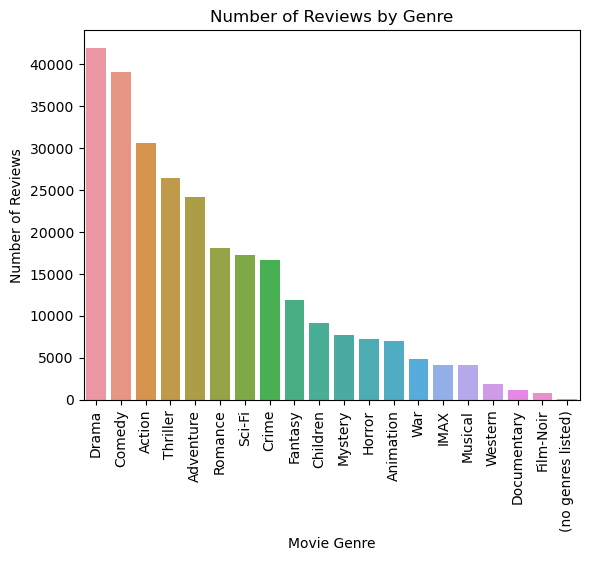

In [7]:
ratingByGenre = pd.merge(df_movies, df_ratings, on='movieId').iloc[:, 2:-3].sum().sort_values(ascending=False)
sns.barplot(x=ratingByGenre.index, y=ratingByGenre.values)
plt.xticks(rotation=90)
plt.title("Number of Reviews by Genre")
plt.ylabel("Number of Reviews")
plt.xlabel("Movie Genre")

# Phase 2

In [8]:
grouped_ratings = df_ratings.groupby('userId')
output = pd.DataFrame()
result_df = pd.merge(df_ratings, df_movies, on='movieId').drop('movieId', axis=1)
result_df = result_df[['userId', 'title']]
result_df = result_df.groupby('userId')['title'].agg(list).reset_index()
result_df.set_index('userId')
result_df.head()

,userId,title
0,1,"[Toy Story (1995), Grumpier Old Men (1995), He..."
1,2,"[Tommy Boy (1995), Gladiator (2000), Shawshank..."
2,3,"[Schindler's List (1993), Highlander (1986), C..."
3,4,"[Seven (a.k.a. Se7en) (1995), Ed Wood (1994), ..."
4,5,"[Toy Story (1995), Usual Suspects, The (1995),..."


In [9]:
te = TransactionEncoder()
transactions = result_df['title'].tolist()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df
mx_df = apriori(df, min_support=0.2, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

,support,itemsets
25,0.539344,(Forrest Gump (1994))
63,0.519672,"(Shawshank Redemption, The (1994))"
57,0.503279,(Pulp Fiction (1994))
65,0.457377,"(Silence of the Lambs, The (1991))"
46,0.455738,"(Matrix, The (1999))"
70,0.411475,(Star Wars: Episode IV - A New Hope (1977))
38,0.390164,(Jurassic Park (1993))
14,0.388525,(Braveheart (1995))
173,0.378689,"(Forrest Gump (1994), Shawshank Redemption, Th..."
168,0.377049,"(Forrest Gump (1994), Pulp Fiction (1994))"


In [10]:
rules = association_rules(mx_df, metric="confidence", min_threshold=0.7)
sorted_rules = rules.sort_values(by='confidence', ascending=False)
sorted_rules.head(20)
for index, row in sorted_rules.head(20).iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    support = row['support']
    print(f"Rule: {antecedents} => {consequents} | Support: {support:.3f}\n")

Rule: Star Wars: Episode VI - Return of the Jedi (1983), Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) => Star Wars: Episode IV - A New Hope (1977) | Support: 0.205

Rule: Star Wars: Episode V - The Empire Strikes Back (1980), Matrix, The (1999), Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) => Star Wars: Episode IV - A New Hope (1977) | Support: 0.200

Rule: Star Wars: Episode V - The Empire Strikes Back (1980), Star Wars: Episode VI - Return of the Jedi (1983), Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) => Star Wars: Episode IV - A New Hope (1977) | Support: 0.200

Rule: Lord of the Rings: The Two Towers, The (2002), Matrix, The (1999), Lord of the Rings: The Return of the King, The (2003) => Lord of the Rings: The Fellowship of the Ring, The (2001) | Support: 0.213

Rule: Star Wars: Episode VI - Return of the Jedi (1983), Raiders of the Lost Ark (Indiana Jones and the Raiders of the

We can draw a number of conclusions from this data, most strikingly among them the fact that a movie being part of a series is a fairly strong predictor that someone will watch another movie in that series. This is seen in groups like Star Wars, Indiana Jones, The Godfather and Lord of the Rings, as if a reviewer watched one movie in the series, they had a heighened likelyhood of watching another. Another conclusion that we can draw is that reviewers who watched movies that are traditionally considered "classics" (Pulp Fiction, The Matrix, Fight Club, etc) or highly poular movies were also more likely to watch other movies that fell into that category.

# Phase 3

In [14]:
comedy_movies = df_movies[df_movies['Comedy'] == 1].copy()
comedy_movies.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Sabrina (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
grouped_ratings = df_ratings.groupby('userId')
output = pd.DataFrame()
result_df = pd.merge(df_ratings, comedy_movies, on='movieId', how = 'inner').drop('movieId', axis=1)
result_df = result_df[['userId', 'title']]
result_df = result_df.groupby('userId')['title'].agg(list).reset_index()
result_df.set_index('userId')
print(result_df.head())

transactions = result_df['title'].tolist()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df
mx_df = apriori(df, min_support=0.2, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

   userId                                              title
0       1  [Toy Story (1995), Grumpier Old Men (1995), Fr...
1       2  [Tommy Boy (1995), Talladega Nights: The Balla...
2       3  [Operation Dumbo Drop (1995), Wallace & Gromit...
3       4  [Ed Wood (1994), Pulp Fiction (1994), Dazed an...
4       5  [Toy Story (1995), Pulp Fiction (1994), Mask, ...


,support,itemsets
7,0.540230,(Forrest Gump (1994))
18,0.504105,(Pulp Fiction (1994))
34,0.377668,"(Forrest Gump (1994), Pulp Fiction (1994))"
20,0.353038,(Toy Story (1995))
1,0.300493,(Aladdin (1992))
5,0.297209,(Fargo (1996))
21,0.292282,(True Lies (1994))
2,0.280788,(Back to the Future (1985))
19,0.279146,(Shrek (2001))
11,0.270936,(Men in Black (a.k.a. MIB) (1997))


In [16]:
rules = association_rules(mx_df, metric="confidence", min_threshold=0.7)
sorted_rules = rules.sort_values(by='confidence', ascending=False)
sorted_rules.head(20)
for index, row in sorted_rules.head(20).iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    support = row['support']
    print(f"Rule: {antecedents} => {consequents} | Support: {support:.3f}\n")

Rule: Mrs. Doubtfire (1993) => Forrest Gump (1994) | Support: 0.222

Rule: Pretty Woman (1990) => Forrest Gump (1994) | Support: 0.205

Rule: Men in Black (a.k.a. MIB) (1997) => Forrest Gump (1994) | Support: 0.220

Rule: Mask, The (1994) => Forrest Gump (1994) | Support: 0.209

Rule: Fargo (1996) => Pulp Fiction (1994) | Support: 0.236

Rule: Back to the Future (1985) => Forrest Gump (1994) | Support: 0.223

Rule: Ace Ventura: Pet Detective (1994) => Forrest Gump (1994) | Support: 0.209

Rule: Mask, The (1994) => Pulp Fiction (1994) | Support: 0.202

Rule: True Lies (1994) => Forrest Gump (1994) | Support: 0.228

Rule: True Lies (1994) => Pulp Fiction (1994) | Support: 0.227

Rule: Aladdin (1992) => Forrest Gump (1994) | Support: 0.232

Rule: Ace Ventura: Pet Detective (1994) => Pulp Fiction (1994) | Support: 0.204

Rule: Shrek (2001) => Forrest Gump (1994) | Support: 0.210

Rule: Pulp Fiction (1994) => Forrest Gump (1994) | Support: 0.378

Rule: Toy Story (1995) => Forrest Gump (1994

In [17]:
music_movies = df_movies[df_movies['Musical'] == 1].copy()
music_movies.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
44,48,Pocahontas (1995),0,0,0,1,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
95,107,Muppet Treasure Island (1996),0,0,1,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
168,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
208,242,Farinelli: il castrato (1994),0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
304,346,Backbeat (1993),0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [18]:
grouped_ratings = df_ratings.groupby('userId')
output = pd.DataFrame()
result_df = pd.merge(df_ratings, music_movies, on='movieId', how = 'inner').drop('movieId', axis=1)
result_df = result_df[['userId', 'title']]
result_df = result_df.groupby('userId')['title'].agg(list).reset_index()
result_df.set_index('userId')
print(result_df.head())

transactions = result_df['title'].tolist()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df
mx_df = apriori(df, min_support=0.2, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

   userId                                              title
0       1  [Pinocchio (1940), James and the Giant Peach (...
1       3                              [My Fair Lady (1964)]
2       4  [Wizard of Oz, The (1939), Sword in the Stone,...
3       5  [Pinocchio (1940), Aladdin (1992), Beauty and ...
4       6  [Pinocchio (1940), Willy Wonka & the Chocolate...


,support,itemsets
0,0.389362,(Aladdin (1992))
2,0.365957,"(Lion King, The (1994))"
1,0.310638,(Beauty and the Beast (1991))
5,0.270213,"(Aladdin (1992), Lion King, The (1994))"
4,0.261702,"(Aladdin (1992), Beauty and the Beast (1991))"
3,0.253191,(Willy Wonka & the Chocolate Factory (1971))
6,0.238298,"(Lion King, The (1994), Beauty and the Beast (..."
7,0.214894,"(Aladdin (1992), Lion King, The (1994), Beauty..."


In [19]:
rules = association_rules(mx_df, metric="confidence", min_threshold=0.7)
sorted_rules = rules.sort_values(by='confidence', ascending=False)
sorted_rules.head(20)
for index, row in sorted_rules.head(20).iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    support = row['support']
    print(f"Rule: {antecedents} => {consequents} | Support: {support:.3f}\n")

Rule: Lion King, The (1994), Beauty and the Beast (1991) => Aladdin (1992) | Support: 0.215

Rule: Beauty and the Beast (1991) => Aladdin (1992) | Support: 0.262

Rule: Aladdin (1992), Beauty and the Beast (1991) => Lion King, The (1994) | Support: 0.215

Rule: Aladdin (1992), Lion King, The (1994) => Beauty and the Beast (1991) | Support: 0.215

Rule: Beauty and the Beast (1991) => Lion King, The (1994) | Support: 0.238

Rule: Lion King, The (1994) => Aladdin (1992) | Support: 0.270



In [21]:
fantasy_movies = df_movies[df_movies['Fantasy'] == 1].copy()
fantasy_movies.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,29,"City of Lost Children, The (Cité des enfants p...",0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
40,44,Mortal Kombat (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,60,"Indian in the Cupboard, The (1995)",0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
grouped_ratings = df_ratings.groupby('userId')
output = pd.DataFrame()
result_df = pd.merge(df_ratings, fantasy_movies, on='movieId', how = 'inner').drop('movieId', axis=1)
result_df = result_df[['userId', 'title']]
result_df = result_df.groupby('userId')['title'].agg(list).reset_index()
result_df.set_index('userId')
print(result_df.head())

transactions = result_df['title'].tolist()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df
mx_df = apriori(df, min_support=0.2, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

   userId                                              title
0       1  [Toy Story (1995), Mask, The (1994), Pinocchio...
1       3  [Highlander (1986), Conan the Barbarian (1982)...
2       4  [Wizard of Oz, The (1939), Sword in the Stone,...
3       5  [Toy Story (1995), Mask, The (1994), Pinocchio...
4       6  [Mask, The (1994), Pinocchio (1940), Willy Won...


,support,itemsets
11,0.368782,(Toy Story (1995))
2,0.339623,(Lord of the Rings: The Fellowship of the Ring...
4,0.322470,"(Lord of the Rings: The Two Towers, The (2002))"
3,0.317324,"(Lord of the Rings: The Return of the King, Th..."
10,0.291595,(Shrek (2001))
14,0.284734,"(Lord of the Rings: The Two Towers, The (2002)..."
13,0.283019,(Lord of the Rings: The Fellowship of the Ring...
17,0.276158,"(Lord of the Rings: The Two Towers, The (2002)..."
5,0.269297,"(Mask, The (1994))"
20,0.264151,"(Lord of the Rings: The Two Towers, The (2002)..."


In [23]:
rules = association_rules(mx_df, metric="confidence", min_threshold=0.7)
sorted_rules = rules.sort_values(by='confidence', ascending=False)
sorted_rules.head(20)
for index, row in sorted_rules.head(20).iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    support = row['support']
    print(f"Rule: {antecedents} => {consequents} | Support: {support:.3f}\n")

Rule: Lord of the Rings: The Two Towers, The (2002), Lord of the Rings: The Return of the King, The (2003) => Lord of the Rings: The Fellowship of the Ring, The (2001) | Support: 0.264

Rule: Lord of the Rings: The Fellowship of the Ring, The (2001), Lord of the Rings: The Return of the King, The (2003) => Lord of the Rings: The Two Towers, The (2002) | Support: 0.264

Rule: Lord of the Rings: The Two Towers, The (2002), Lord of the Rings: The Fellowship of the Ring, The (2001) => Lord of the Rings: The Return of the King, The (2003) | Support: 0.264

Rule: Lord of the Rings: The Return of the King, The (2003) => Lord of the Rings: The Fellowship of the Ring, The (2001) | Support: 0.283

Rule: Lord of the Rings: The Two Towers, The (2002) => Lord of the Rings: The Fellowship of the Ring, The (2001) | Support: 0.285

Rule: Lord of the Rings: The Return of the King, The (2003) => Lord of the Rings: The Two Towers, The (2002) | Support: 0.276

Rule: Lord of the Rings: The Two Towers, The 

This method has it's drawbacks and it's benefits. In categories with a smaller amount of movies and reviews like Musical, the conclusions that can be drawn are somewhat limited just as a consequence of the limited sample size. In categories with larger amounts of movies and reviews there are many interesting conclusions to be drawn, as to the relationships between movies. However there are some issues with this strategy, primarily among them that it isn't clear that the driving force behind the decision to watch a movie is genre. In cases like Star Wars, the genre is less the reason for watching the movie than the name is, people aren't watching it because it is an Adventure movie, they're watching it because it is Star Wars. So by limiting the movies that we are parsing to just one genre, we might miss out on important conclusions as to how people decide what to watch.

# Phase 4

In [24]:
df_movies_genres = df_movies.set_index('title').drop(['movieId'], axis=1)
result_df_genres = result_df.set_index('title')
genres = pd.DataFrame(np.nan, index=range(len(result_df)), columns=["genres"])
for index,row in result_df.iterrows():
    if index % 50 == 0:
        print(index)
    genre = pd.Series(name='genres')
    for i in row[1]:
        genre = pd.concat([genre, pd.Series(df_movies_genres.loc[[i]].columns[np.where((df_movies_genres.loc[i]) == 1)])], ignore_index=True)
    genre = genre.drop_duplicates()
    genres.genres[index] = genre.to_list()
result_df['genres'] = genres

0
50
100
150
200
250
300
350
400
450
500
550


The printed numbers here were to ensure my computer did not crash while running the above.

**What genres of movies did users watch?**

In [25]:
te = TransactionEncoder()
transactions = result_df['genres'].tolist()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
mx_df = apriori(df, min_support=0.7, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

,support,itemsets
6,1.000000,(Fantasy)
4,0.917667,(Comedy)
24,0.917667,"(Comedy, Fantasy)"
15,0.890223,"(Adventure, Fantasy)"
1,0.890223,(Adventure)
13,0.833619,"(Adventure, Comedy)"
37,0.833619,"(Adventure, Comedy, Fantasy)"
21,0.826758,"(Children, Fantasy)"
3,0.826758,(Children)
10,0.801029,"(Fantasy, Action)"


# Phase 5

In [26]:
ratingByMovie

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64

In [27]:
df_movie_ratings = pd.merge(df_movies, df_ratings.groupby('movieId')['rating'].mean(), on='movieId')

In [28]:
df_movie_ratings

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3.920930
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.431818
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.259615
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,2.357143
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.000000
9720,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.500000
9721,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.500000
9722,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.500000


In [29]:
bad_movies = df_movie_ratings[df_movie_ratings['rating'] < 2].copy()
bad_movies

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
63,71,Fair Game (1995),0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.7
125,152,"Addiction, The (1995)",0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1.5
150,178,Love & Human Remains (1993),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
151,179,Mad Love (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.5
240,278,Miami Rhapsody (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,190207,Tilt (2011),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.5
9709,190213,John From (2015),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
9710,190215,Liquid Truth (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.5
9711,190219,Bunny (1998),0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


**What are the genres of movies with the lowest average ratings?**

In [30]:
bad_movies.replace(0, False, inplace=True)
bad_movies.replace(1, True, inplace=True)
mx_df = apriori(bad_movies.iloc[:, 2:-1], min_support=0.2, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

,support,itemsets
1,0.430818,(Comedy)
2,0.265723,(Drama)
0,0.238994,(Action)
3,0.213836,(Horror)


In [31]:
good_movies = df_movie_ratings[df_movie_ratings['rating'] > 4].copy()
good_movies

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
27,28,Persuasion (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4.227273
28,29,"City of Lost Children, The (Cité des enfants p...",0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,4.013158
36,40,"Cry, the Beloved Country (1995)",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.250000
46,50,"Usual Suspects, The (1995)",0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,4.237745
48,53,Lamerica (1994),0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9693,187717,Won't You Be My Neighbor? (2018),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000
9694,188189,Sorry to Bother You (2018),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,4.500000
9697,188751,Mamma Mia: Here We Go Again! (2018),0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,4.500000
9699,188833,The Man Who Killed Don Quixote (2018),0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.500000


**What are the genres of movies with the highest average ratings?**


In [32]:
good_movies.replace(0, False, inplace=True)
good_movies.replace(1, True, inplace=True)
mx_df = apriori(good_movies.iloc[:, 2:-1], min_support=0.1, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

,support,itemsets
3,0.512698,(Drama)
1,0.353968,(Comedy)
4,0.162698,(Romance)
5,0.130952,(Thriller)
2,0.125397,(Crime)
0,0.115873,(Action)
6,0.112698,"(Comedy, Drama)"
7,0.105556,"(Romance, Drama)"


In [33]:
df_movies

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_movies['year'] = df_movies.title.str.split(" ").str[-1].str[1:-1]
df_movies = df_movies.drop(np.where(df_movies.year.str.isdigit() != True)[0])
df_movies.year = df_movies.year.astype('int32')

In [38]:
eighties = df_movies[(df_movies.year > 1979) & (df_movies.year < 1990)]
seventies = df_movies[(df_movies.year > 1969) & (df_movies.year < 1980)]
nineties = df_movies[(df_movies.year > 1989) & (df_movies.year < 2000)]

**What are the most common movie genres of movies from the 70's?**

In [39]:
seventies.replace(0, False, inplace=True)
seventies.replace(1, True, inplace=True)
mx_df = apriori(seventies.iloc[:, 2:-2], min_support=0.1, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

/var/folders/n6/flv24c7166ng1dcpptql4gv00000gn/T/ipykernel_54002/1987067894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seventies.replace(0, False, inplace=True)
/var/folders/n6/flv24c7166ng1dcpptql4gv00000gn/T/ipykernel_54002/1987067894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seventies.replace(1, True, inplace=True)


,support,itemsets
4,0.450902,(Drama)
2,0.310621,(Comedy)
0,0.204409,(Action)
7,0.190381,(Thriller)
3,0.140281,(Crime)
1,0.140281,(Adventure)
5,0.126253,(Horror)
6,0.116232,(Sci-Fi)


**What are the most common movie genres of movies from the 80's?**


In [40]:
eighties.replace(0, False, inplace=True)
eighties.replace(1, True, inplace=True)
mx_df = apriori(eighties.iloc[:, 2:-2], min_support=0.1, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

/var/folders/n6/flv24c7166ng1dcpptql4gv00000gn/T/ipykernel_54002/2294529817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eighties.replace(0, False, inplace=True)
/var/folders/n6/flv24c7166ng1dcpptql4gv00000gn/T/ipykernel_54002/2294529817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eighties.replace(1, True, inplace=True)


,support,itemsets
2,0.418012,(Comedy)
4,0.372982,(Drama)
0,0.192863,(Action)
8,0.152931,(Thriller)
5,0.149533,(Horror)
1,0.144435,(Adventure)
7,0.132540,(Sci-Fi)
6,0.130841,(Romance)
3,0.105353,(Crime)


**What are the most common movie genres of movies from the 90's?**

In [41]:
nineties.replace(0, False, inplace=True)
nineties.replace(1, True, inplace=True)
mx_df = apriori(nineties.iloc[:, 2:-2], min_support=0.1, use_colnames=True)
top_20_frequent_patterns = mx_df.sort_values(by='support', ascending=False).head(20)

top_20_frequent_patterns

/var/folders/n6/flv24c7166ng1dcpptql4gv00000gn/T/ipykernel_54002/844408072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nineties.replace(0, False, inplace=True)
/var/folders/n6/flv24c7166ng1dcpptql4gv00000gn/T/ipykernel_54002/844408072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nineties.replace(1, True, inplace=True)


,support,itemsets
4,0.469896,(Drama)
2,0.401992,(Comedy)
5,0.191037,(Romance)
6,0.190131,(Thriller)
0,0.177456,(Action)
3,0.119058,(Crime)
7,0.115437,"(Comedy, Drama)"
8,0.114079,"(Romance, Drama)"
1,0.107741,(Adventure)
